In [1]:
## 자산 및 전략에 대해 기본적인 평가를 수행할 수 있습니다.

In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import json

# 시각화
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
## fred = Fred(api_key='Your API Key')

fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## DataLoad

In [4]:
## 필수 데이터

## 사전에 획득한 금, 다우존스배당지수
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
## DFF: Federal Funds Rate, DTB3: 3개월 미국 국채 금리, DGS2: 2년 미국 국채 금리, DGS10: 10년 미국 국채 금리, DGS20: 20년 미국 국채 금리
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')
ds2 = fred.get_series('DGS2').fillna(method='pad')
tb3 = fred.get_series('DTB3').fillna(method='pad')
dff = fred.get_series('DFF').fillna(method='pad')
## rec = fred.get_series('USREC').fillna(method='pad') ## 월간 경기침체 데이터 ## 별도 수집 데이터로 대체

## 기본지수 데이터
## ^IXIC : 나스닥종합주가지수, ^GSPC: S&P500지수, ^DJI: 다우존스지수, GC=F : 금선물지수
tickers = ['^IXIC', '^GSPC', '^DJI', 'GC=F']
df_ref = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ref = df_ref['Close']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div'].copy()
df_ref['Gold'] = gold['Gold'].copy()
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20
df_ref['DGS2'] = ds2
df_ref['DTB3'] = tb3

[*********************100%***********************]  4 of 4 completed


## Preprocessing

In [5]:
## Imputation
df_ref_imp = mf.imputation(df_ref, '^GSPC', '^DJI') ## S&P500를 기준으로 다우존스 지수 보간
df_ref_imp = mf.imputation(df_ref_imp, '^DJI', 'Div') ## 다우존스 지수를 기준으로 배당지수 보간
df_ref_imp = mf.imputation(df_ref_imp, 'DGS10', 'DGS20', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS20', 'DGS10', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS10', 'DGS2', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS2', 'DTB3', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'GC=F', 'Gold') ## 금 선물 가격을 기준으로 금 가격 보간
## column selection
df_ref_imp = df_ref_imp[['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']]

0.9181879406572258
0.8698779253276526
0.8865281593571428
1.0151419557951686
0.6601264774034237
0.708689165507758
0.9953424146502147


In [6]:
df_ref_scaled = df_ref_imp.copy()
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold']
df_ref_scaled[_cols] = df_ref_scaled[_cols]/df_ref_scaled[_cols].iloc[0] * 100
df_ref_scaled.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']
df_ref_scaled['Cash'] = (df_ref_scaled['DTB3']/100 * 1/252 + 1).shift(1).fillna(1).cumprod() * 100

## Target Data

In [7]:
## 프로젝트마다 필요한 데이터
tickers = ['SCHD', 'SPY', 'QQQ', 'TQQQ', 'TLT', 'SGOV', 'IAU']
df_ori = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ori = df_ori['Close']

[*********************100%***********************]  7 of 7 completed


In [8]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref_scaled, df_ori], axis=1)
df_imp = mf.imputation(df_imp, 'Div', 'SCHD')
df_imp = mf.imputation(df_imp, 'S&P500', 'SPY')
df_imp = mf.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = mf.imputation(df_imp, 'QQQ', 'TQQQ')
df_imp = mf.imputation(df_imp, 'DGS20', 'TLT')
df_imp = mf.imputation(df_imp, 'Cash', 'SGOV')
df_imp = mf.imputation(df_imp, 'Gold', 'IAU')
df_imp = df_imp[tickers]
df_imp = df_imp/df_imp.iloc[0] * 100

0.9940905698362733
0.9936231329572222
1.0443647375992129
2.9810311776282585
-0.30415144764071717
1.0235110488071362
0.8731905317123132


In [9]:
## 데이터 임시 저장
df_imp.to_csv("trend_data.csv", encoding='utf-8-sig')

In [10]:
## df_imp = pd.read_csv("trend_data.csv", index_col=0)

In [11]:
df_imp.index = pd.to_datetime(df_imp.index)

In [12]:
from quant_functions import anal_funcs as qaf

In [13]:
tt = qaf.get_YTD_report(df_imp[['QQQ']], 'a').T

In [14]:
qaf.get_Vol_report(df_imp[['QQQ']], 'a', rf=0)[['Return', 'Volatility', 'Volatility(Down)', 'Sharpe_Ratio', 'Sortino_Ratio']]

,Return,Volatility,Volatility(Down),Sharpe_Ratio,Sortino_Ratio
Ticker,,,,,
QQQ,13.21,6.27,4.69,2.11,2.82


In [15]:
def calculate_drawdown(data):
    peak = data.expanding(min_periods=1).max()
    drawdown = (data - peak) / peak
    return drawdown

In [16]:
tt = calculate_drawdown(df_imp)

In [17]:
drawdowns = {asset: calculate_drawdown(tt[asset]) for asset in ['QQQ']}

In [18]:
tt

,SCHD,SPY,QQQ,TQQQ,TLT,SGOV,IAU
Date,,,,,,,
1975-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1975-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1975-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001500
1975-01-07,-0.000559,-0.000699,0.000000,0.000000,0.000000,0.0,-0.006501
1975-01-08,-0.011524,-0.014401,-0.006580,-0.019488,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
2025-03-04,-0.055018,-0.058848,-0.081498,-0.259179,-0.390593,0.0,-0.011494
2025-03-05,-0.050618,-0.048733,-0.069525,-0.230320,-0.395458,0.0,-0.009160
2025-03-06,-0.049941,-0.065619,-0.095122,-0.294131,-0.397458,0.0,-0.014547


## Visualization(Basic)

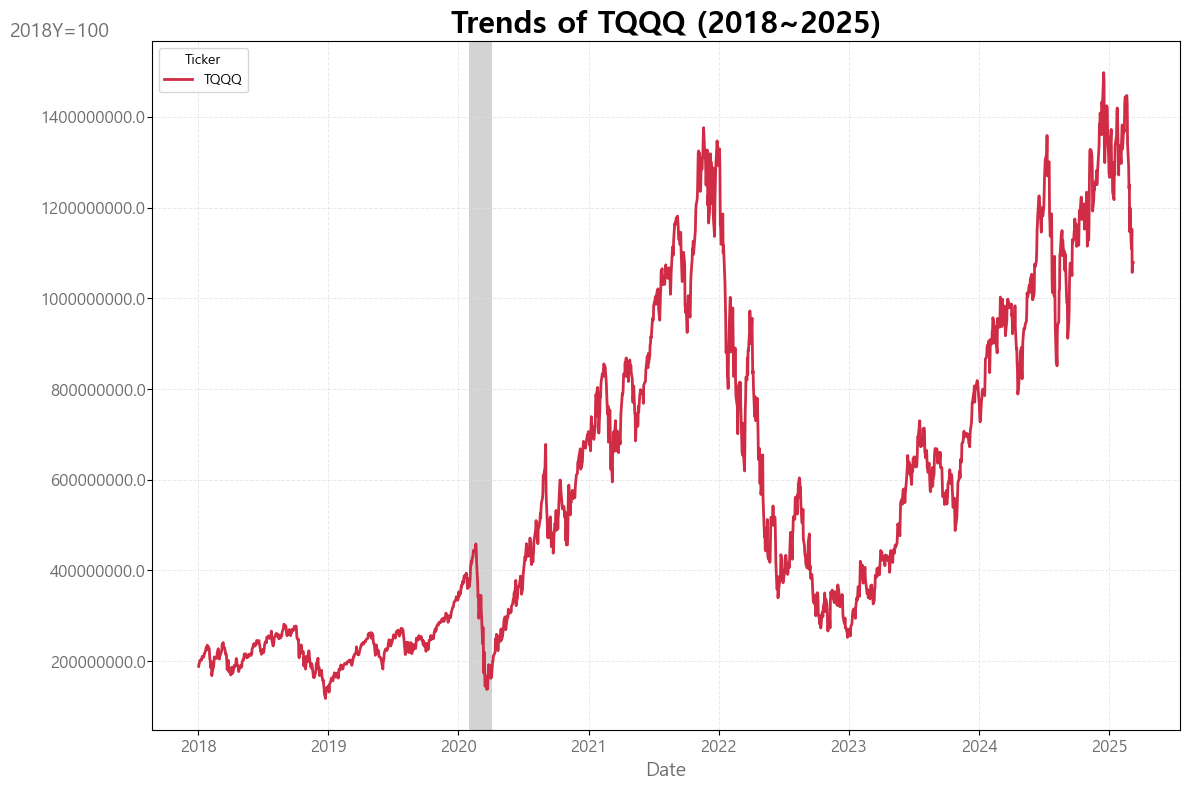

In [19]:
gm.trend_plot(df_imp['2018':], ['TQQQ'], colors=[mycolors['color_norm'], mycolors['color_cont']], yscale='linear')

# 기본버전
# df_imp[['QQQ']].plot()
# plt.yscale('log')
# plt.show()

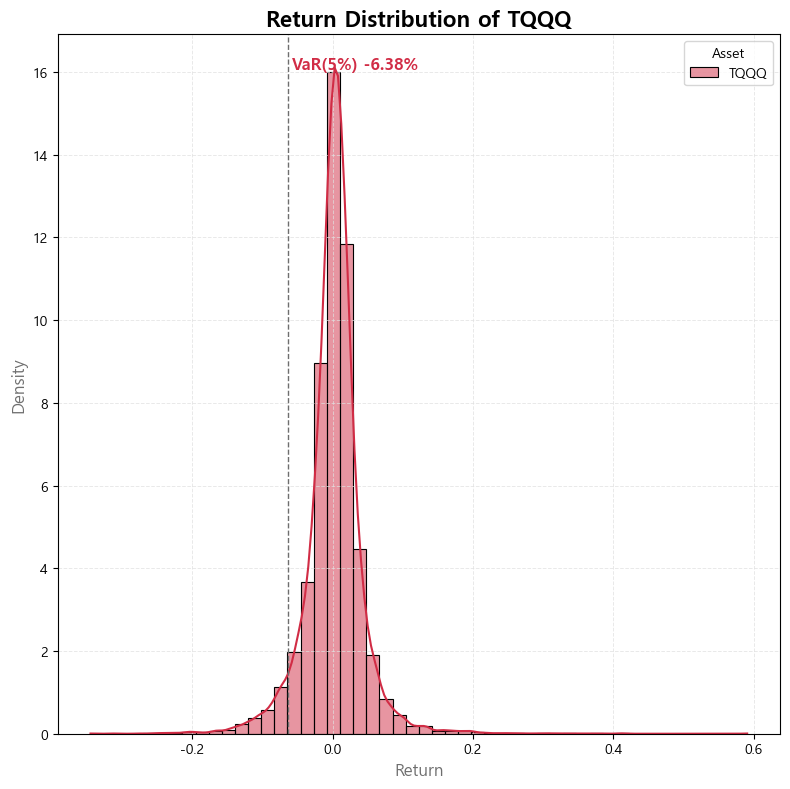

In [20]:
gm.asset_histogram_plot(df_imp.pct_change(), ['TQQQ'], colors=[mycolors['color_norm'], mycolors['color_cont']])

## 기본버전
# df_imp[['QQQ']].pct_change().plot(kind='hist', bins=100)

In [21]:
## MDD 계산
data = df_imp['SCHD'].copy()
peak = data.expanding(min_periods=1).max()
drawdown = (data - peak) / peak

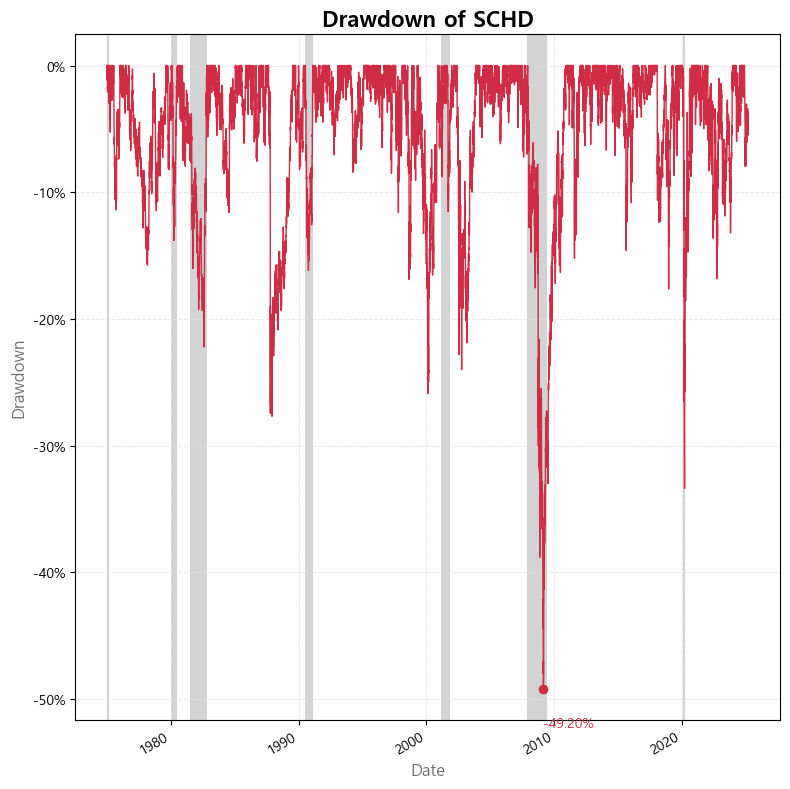

In [22]:
gm.drawdown_plot(df_imp, ['SCHD'], colors=[mycolors['color_norm'], mycolors['color_cont']])

## 기본버전
# drawdown.plot()

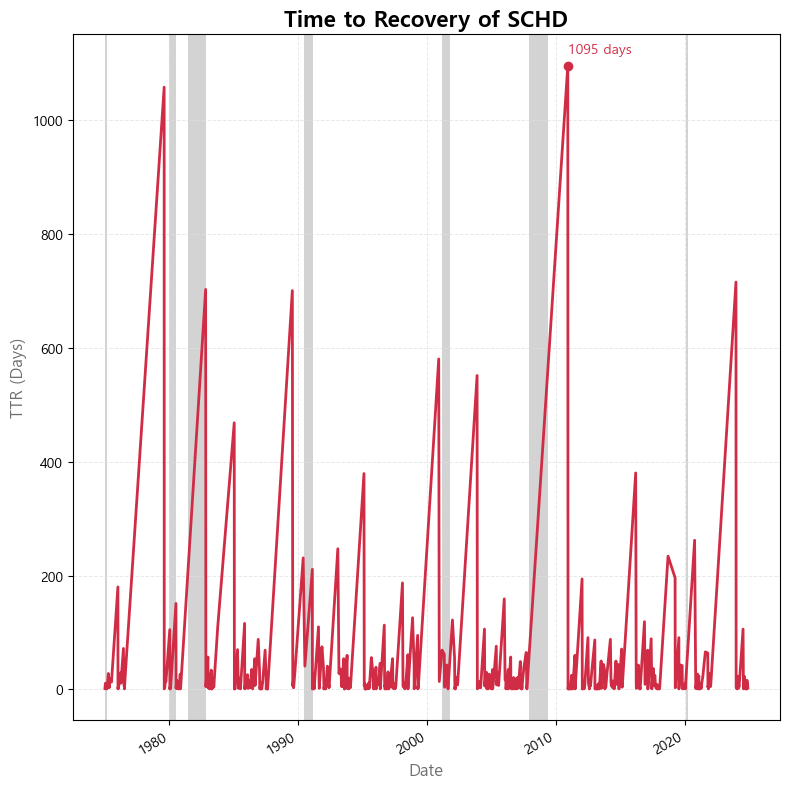

In [23]:
## ttr 계산
ttr_df = mf.get_ttr_df(df_imp, ['SCHD'])

gm.ttr_plot(ttr_df, ['SCHD'], colors=[mycolors['color_norm'], mycolors['color_cont']])

## 기본버전
# ttr_df.plot()

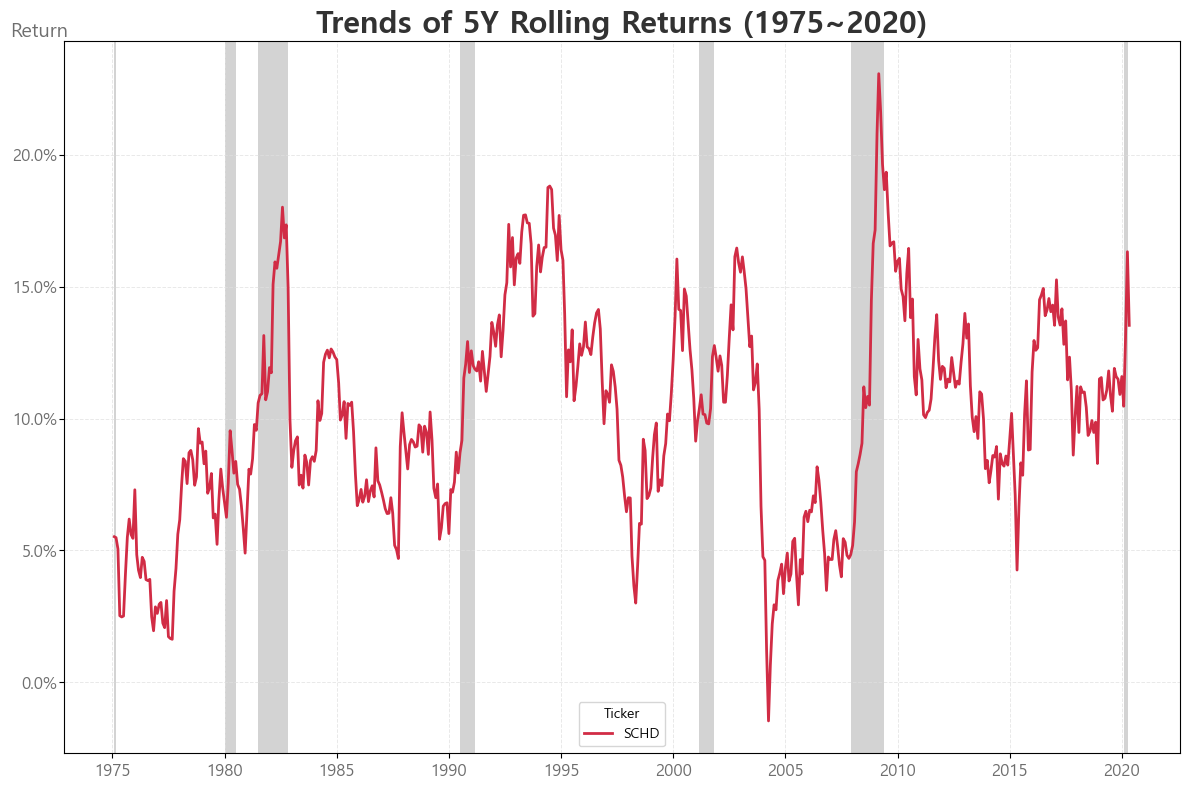

In [58]:
rr_df = mf.get_rr_df(df_imp, ['SCHD'])
gm.rr_trend_plot(rr_df, ['SCHD'], colors=[mycolors['color_norm'], mycolors['color_cont']])

## 기본버전
# rr_df.plot()

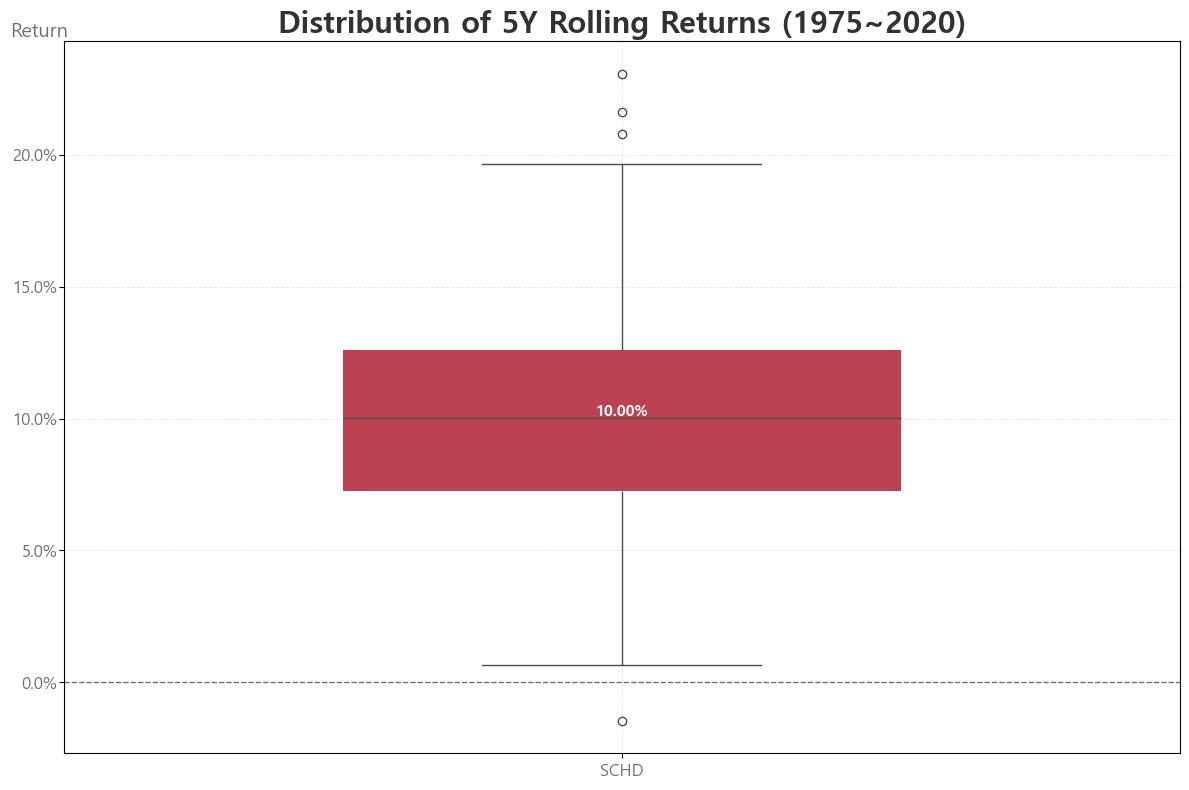

In [59]:
gm.rr_box_plot(rr_df, ['SCHD'], colors=[mycolors['color_norm'], mycolors['color_cont']])

## 기본버전
# rr_df.plot(kind='box')

In [65]:
_mean = rr_df.mean()
_std = rr_df.std()

validation = pd.DataFrame([_mean, _std], index=['기대수익률', '변동성']).T.round(2)
validation['하방'] = validation['기대수익률'] - validation['변동성']*2
validation['상방'] = validation['기대수익률'] + validation['변동성']*2
validation['하방주의'] = validation['하방'] <= 0
validation['변동주의'] = validation['변동성'] >= validation['기대수익률']*.5

In [68]:
validation['기대수익률']['SCHD']
validation['하방']['SCHD']
validation['상방']['SCHD']
validation['하방주의']['SCHD']
validation['변동주의']['SCHD']

10.01

In [69]:
validation

,기대수익률,변동성,하방,상방,하방주의,변동주의
SCHD,10.01,3.98,2.05,17.97,False,False


In [63]:
validation

,기대수익률,상방,하방,하방위험성
SCHD,10.0,17.97,2.06,False


In [ ]:
validation['상방']

In [30]:
rr_df.mean() - rr_df.std()

TQQQ    35.445548
dtype: float64

In [36]:
rr_df.max()

TQQQ    204.0513
dtype: float64